In [43]:
import scipy.io as io
import numpy as np
import scipy.sparse.csgraph as cs
import scipy.sparse as sparse
import math
import random
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import time
import queue

In [44]:
def MSSP_ultimate(graph, pivots):
    weights = {}
    dists = {}
    I, J, V = sparse.find(graph)
    for e in range(len(I)):
        i, j, v = I[e], J[e], V[e]
        if i < j:
            weights[(i, j)] = weights[(j, i)] = 1 / v ** 2
            dists[(i, j)] = dists[(j, i)] = v

    n = graph.shape[0]
    graph_arr = graph.toarray()

    # initialize s for each pivot
    s = {}

    mark_for_region = [False] * n
    mark_for_weights = {}
    level = {}
    regions = {}
    region_assignment = [-1] * n
    q1 = queue.Queue()
    q2 = {}
    q3 = queue.Queue()

    dist = {}
    prev_dist = {}

    for p in pivots:
        regions[p] = [p]
        region_assignment[p] = p
        q1.put(p)
        q2[p] = queue.Queue()
        mark_for_weights[p] = [False] * n
        mark_for_weights[p][p] = True
        level[p] = [0] * n
        mark_for_region[p] = True
        s[p] = 1
        dist[p] = 0
        prev_dist[p] = 1

    while not q1.empty():
        index = q1.get()
        pivot_index = region_assignment[index]
        cur_level = level[pivot_index][index]

        if cur_level > dist[pivot_index]:
            dist[pivot_index] = cur_level

        compute_s(q2, pivot_index, level, dist, prev_dist, s)

        if pivot_index != index and graph[pivot_index, index] == 0 and (pivot_index, index) not in weights and (index, pivot_index) not in weights:
            compute_weight(index, pivot_index, weights, dists, level, s)

        neighbours = graph_arr[index].nonzero()[0]
        for neighbour in neighbours:
            if not mark_for_region[neighbour]:
                mark_for_region[neighbour] = True
                mark_for_weights[pivot_index][neighbour] = True
                level[pivot_index][neighbour] = cur_level + 1
                q1.put(neighbour)
                region_assignment[neighbour] = pivot_index
                regions[pivot_index].append(neighbour)
                q2[pivot_index].put(neighbour)
            if not mark_for_weights[pivot_index][neighbour]:
                mark_for_weights[pivot_index][neighbour] = True
                level[pivot_index][neighbour] = cur_level + 1
                q3.put((neighbour, pivot_index))

    while not q3.empty():
        index, pivot_index = q3.get()
        cur_level = level[pivot_index][index]

        if cur_level > dist[pivot_index]:
            dist[pivot_index] = cur_level

        compute_s(q2, pivot_index, level, dist, prev_dist, s)
        compute_weight(index, pivot_index, weights, dists, level, s)

        neighbours = graph_arr[index].nonzero()[0]
        for neighbour in neighbours:
            if not mark_for_weights[pivot_index][neighbour]:
                mark_for_weights[pivot_index][neighbour] = True
                level[pivot_index][neighbour] = cur_level + 1
                q3.put((neighbour, pivot_index))

    return dists, weights


def compute_s(q2, pivot_index, level, dist, prev_dist, s):
    if dist[pivot_index] % prev_dist[pivot_index] == 0 and dist[pivot_index] / prev_dist[pivot_index] == 2:
        while not q2[pivot_index].empty():
            regional_index = q2[pivot_index].get()
            if level[pivot_index][regional_index] <= prev_dist[pivot_index]:
                s[pivot_index] += 1
            else:
                q2[pivot_index].put(regional_index)
                break
        prev_dist[pivot_index] += 1


def compute_weight(index, pivot_index, weights, dists, level, s):
    weights[(index, pivot_index)] = s[pivot_index] / level[pivot_index][index] ** 2
    if (pivot_index, index) not in weights:
        weights[(pivot_index, index)] = 0
    dists[(pivot_index, index)] = dists[(index, pivot_index)] = level[pivot_index][index]


In [45]:
# graph_name = 'commanche_weighted'
# mat_data = io.loadmat(graph_name + '.mat')
# graph = mat_data['graph']
graph_name = 'vsp_p0291_seymourl_iiasa'
mat_data = io.loadmat(graph_name + '.mat')
graph = mat_data['Problem']['A'][0][0]
graph_arr = graph.toarray()

# get number of vertices
n = graph.shape[0]
num_of_pivots = 2000

program_start_time = time.time()

# randomly choose a pivot
p0 = np.random.randint(0, n)
pivots = [p0]

# initialize list of minimum distances to each pivots
shortest_paths = {}
shortest_paths[p0] = cs.dijkstra(graph, indices=p0)
mins = []
for i in range(n):
    mins.append([shortest_paths[p0][i], p0])

for i in range(1, num_of_pivots):
    total_probability = 0
    cumulative_probability = []
    for j in range(n):
        
        # probability is proportional to the shortest paths to the pivot
        total_probability += mins[j][0]
        cumulative_probability.append(total_probability)
    
    sample = np.random.uniform(0, total_probability)
    for j in range(n):
        if sample < cumulative_probability[j]:
            pivots.append(j)
            break
    
    shortest_paths[pivots[i]] = cs.dijkstra(graph, indices=pivots[i])
    for j in range(n):
        temp = shortest_paths[pivots[i]][j]
        if temp < mins[j][0]:
            mins[j][0] = temp
            mins[j][1] = pivots[i]

In [46]:
algo_start_time = time.time()
dists, weights = MSSP_ultimate(graph, pivots)
algo_end_time = time.time()
print("algo time: %.2f" % (algo_end_time - algo_start_time))

algo time: 6007.89


#### Implement Multi-Source Shortest Paths

number of constraints found:  19032689
82.0 0.012345679012345678 -0.7931252496379099
....................Computation time: 14297.52


C:\Users\Win10\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


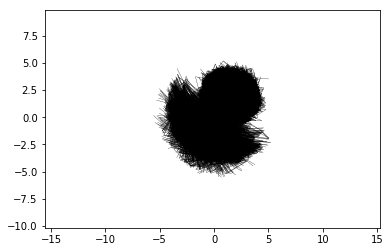

In [47]:
constraints = []
for ij in dists.keys():
    i = ij[0]
    j = ij[1]
    if i < j:
        constraints.append((i, j, dists[ij]))

print("number of constraints found: ", len(constraints))
        
w_max = 0
w_min = math.inf

for w in weights.values():
    if w != 0:
        w_max = max(w, w_max)
        w_min = min(w, w_min)
        
c_max = 1 / w_min
c_min = 0.1 / w_max

num_iter = 25

lambd = np.log(c_min/c_max) / (num_iter-1)
print("{} {} {}".format(w_max, w_min, lambd))

cool = lambda k: c_max * np.exp(lambd*k)

X = np.random.rand(n, 2)
for k in range(num_iter + 5):
    random.shuffle(constraints)
    c = cool(k - 1)

    for i, j, d in constraints:
        w_i = min(weights[(i, j)] * c, 1)
        w_j = min(weights[(j, i)] * c, 1)
        ij = X[i] - X[j]
        mag = np.linalg.norm(ij)
        m = ((d - mag) / 2) * (ij / mag)

        X[i] += w_i * m
        X[j] -= w_j * m

    print('.', end='')

program_end_time = time.time()

print("Computation time: %.2f" % (program_end_time - program_start_time))
    
plt.axis('equal')
ax = plt.axes()
ax.set_xlim(min(X[:, 0])-10, max(X[:, 0])+10)
ax.set_ylim(min(X[:, 1])-10, max(X[:, 1])+10)

lines = []
for i, j in zip(*graph.nonzero()):
    lines.append([X[i], X[j]])

lc = mc.LineCollection(lines, linewidths=.3, colors='#0000007f')
ax.add_collection(lc)

plt.savefig(graph_name + '.svg', dpi=1000)
plt.show()


In [49]:
shortest_paths = cs.dijkstra(graph)
stress = 0
for i in range(n):
    for j in range(i):
        pq = X[i] - X[j]
        mag = np.linalg.norm(pq)
        
        stress += (1/shortest_paths[i,j]**2) * (shortest_paths[i,j]-mag)**2
        
print('stress = {:.0f}'.format(stress))

stress = 7856005
